**Semantic Segmentation via PSPNet (=Pyramid Scene Parsing Network)**

# 0.Make folder and data downloads

In [1]:
import os
import urllib.request
import zipfile
import tarfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/[TNT] 21-winter Pytorch/pytorch_advanced-kr/3_semantic_segmentation')

In [4]:
# data 폴더 없을 시 생성
data_dir = './data/'
if not os.path.exists(data_dir):
  os.mkdir(data_dir)

In [5]:
# weight 폴더 없을 시 생성
weights_dir = './weights/'
if not os.path.exists(weights_dir):
  os.mkdir(weights_dir)

In [ ]:
# VOC2012 데이터셋 다운로드
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, 'VOCtrainval_11-May-2012.tar')

if not os.path.exists(target_path):
  urllib.request.urlretrieve(url, target_path)
  
  tar = tarfile.TarFile(target_path) # tar 파일 읽기
  tar.extractall(data_dir) # tar 파일 압축 해제 
  tar.close() # tar 파일 닫기

In [ ]:
# "weights" 폴더에 네트워크의 초기치로써 사용할 "pspnet50_ADE20K.pth"를
# 필자의 Google Drive에서 다운로드
# https://drive.google.com/open?id=12eN6SpnawYuQmD1k9VgVW3QSgPR6hICc
# file_id="12eN6SpnawYuQmD1k9VgVW3QSgPR6hICc"
# file_name="pspnet50_ADE20K.pth"

!curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=12eN6SpnawYuQmD1k9VgVW3QSgPR6hICc" > /dev/null
!curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=$(awk '/_warning_/ {print $NF}' /tmp/cookie)&id=12eN6SpnawYuQmD1k9VgVW3QSgPR6hICc" -o "pspnet50_ADE20K.pth"

# 파일 이동
!mv pspnet50_ADE20K.pth ./weights

In [ ]:
'''
※미리 실시된 내용
승마 화상 다운로드

https://pixabay.com/ja/photos/%E3%82%AB%E3%82%A6%E3%83%9C%E3%83%BC%E3%82%A4-%E9%A6%AC-%E4%B9%97%E9%A6%AC-%E6%B0%B4-%E6%B5%B7-757575/
640×426 크기의 화상을 "data" 폴더에 배치
(사진의 권리 정보: 상업적 사용 무료, 저작자 표시가 필요하지 않습니다)


'''

In [ ]:
'''
(필자가 작성한) 학습된 PSPNet 모델 "pspnet50_30.pth"

https://drive.google.com/open?id=192JenT9UTHjFb6fhwSdRgOWr8_RmDl4I

반드시 다운로드할 필요는 없지만,
PSPNet을 학습하기 전에, 학습된 모델을 미리 시도해보는 경우,
위 링크에서 수동으로 다운로드한 "pspnet50_30.pth" 파일을 "wights" 폴더에 배치합니다.

'''

# 1.DataLoader

PSPNet 시맨틱 분할용 Dataset과 DataLoader를 작성한다. VOC2012 데이터셋을 대상으로 한다.

## 1.1 패키지 import

In [6]:
import os.path as osp
from PIL import Image

import torch.utils.data as data

## 1.2 이미지 데이터 및 어노테이션 데이터 파일 경로 리스트

In [7]:
def make_datapath_list(rootpath):
  '''
  학습, 검증용 이미지 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다

  Parameters
  ----------
  rootpath : str  (데이터 폴더의 경로)

  Returns
  -------
  ret : train_img_list, train_anno_list, val_img_list, val_anno_list (데이터 경로를 저장한 리스트)

  '''

  # 이미지 파일, 어노테이션 파일경로 템플릿 작성
  imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
  annopath_template =  osp.join(rootpath, 'SegmentationClass', '%s.png')

  # 훈련 및 검증 파일 각각의 ID(파일 이름)를 취득
  train_id_names =  osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
  val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

  # 훈련 데이터의 이미지 파일과 어노테이션 파일의 경로 리스트를 작성
  train_img_list = list()
  train_anno_list = list()

  for line in open(train_id_names):
    file_id = line.strip() # 공백과 줄바꿈 제거
    img_path = (imgpath_template % file_id) # 이미지 경로
    anno_path = (annopath_template % file_id) # 어노테이션 경로
    train_img_list.append(img_path)
    train_anno_list.append(anno_path)
  
  # 검증 데이터의 이미지 파일과 어노테이션 파일의 경로 리스틀 작성
  val_img_list = list()
  val_anno_list = list()
  for line in open(val_id_names):
    file_id = line.strip() # 공백과 줄바꿈 제거
    img_path = (imgpath_template % file_id) # 이미지 경로
    anno_path = (annopath_template % file_id) # 어노테이션 경로
    val_img_list.append(img_path)
    val_anno_list.append(anno_path)

  return train_img_list, train_anno_list, val_img_list, val_anno_list


In [8]:
#  동작 확인 (파일 경로리스트 return)
rootpath = './data/VOCdevkit/VOC2012/'

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath
)

print(train_img_list[0])
print(train_anno_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


## 1.3 Dataset

In [9]:
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

class DataTransform():
  '''
  이미지와 어노테이션 전처리 클래스. 훈련시와 검증시 다르게 동작
  이미지 크기를 input_size x input_size 로 한다
  훈련시에 데이터 확장 수행

  Attributes
  ----------
  input_size : int
      리사이즈 대상 이미지 크기
  color_mean :(R, G, B)
      각 색상 채널의 평균값
  color_srd : (R, G, B)
      각 색상 채널의 표준편차

  '''
  def __init__(self, input_size, color_mean, color_std):
    self.data_transform = {
        'train': Compose([
                  Scale(scale=[0.5, 1.5]), # 이미지 확대
                  RandomRotation(angle=[-10, 10]), # 회전
                  RandomMirror(), # 랜덤 미러
                  Resize(input_size), # 리사이즈
                  Normalize_Tensor(color_mean, color_std) # 색상 정보 표준화와 텐서화
        ]),
        'val': Compose([
                  Resize(input_size),
                  Normalize_Tensor(color_mean, color_std)
        ])
    }

  def __call__(self, phase, img, anno_class_img):
    '''
    Parameters
    ----------
    phase : 'train' or 'val'
        전처리 모드 설정
    '''
    return self.data_transform[phase](img, anno_class_img)

In [10]:
class VOCDataset(data.Dataset):
  '''
  VOC2012의 데이터셋을 만드는 클래스. PyTorch의 Dataset 클래스를 상속받는다

  Attributes
  ----------
  img_list : list
      이미지 경로를 저장한 리스트
  anno_list : list
      어노테이션 경로를 저장한 리스트
  phase : 'train' or 'test'
      학습 또는 테스트 설정
  transform : object
      전처리 클래스의 인스턴스
  '''

  def __init__(self, img_list, anno_list, phase, transform):
    self.img_list = img_list
    self.anno_list = anno_list
    self.phase = phase
    self.transform = transform

  def __len__(self):
    '''이미지 개수를 반환'''
    return len(self.img_list)
  
  def __getitem__(self, index):
    '''전처리한 이미지의 텐서 형식 데이터와 어노테이션 리턴'''
    img, anno_class_img = self.pull_item(index)
    return img, anno_class_img

  def pull_item(self, index):
    '''이미지의 텐서 형식 데이터, 어노테이션을 리턴'''
    # 1. 이미지 읽기
    image_file_path = self.img_list[index]
    img = Image.open(image_file_path) # [높이][폭][색RGB]
    # 2. 어노테이션 이미지 읽기
    anno_file_path = self.anno_list[index]
    anno_class_img = Image.open(anno_file_path) # [높이][폭]
    # 3. 전처리
    img, anno_class_img =  self.transform(self.phase, img, anno_class_img)

    return img, anno_class_img


In [11]:
# 동작 확인

# (RGB) 색의 평균과 표준편차
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# 데이터셋 작성
train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train', transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))
val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val', transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# 데이터 추출하는 예
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))

torch.Size([3, 475, 475])
torch.Size([475, 475])
(tensor([[[ 1.6667,  1.5125,  1.5639,  ...,  1.7523,  1.6667,  1.7009],
         [ 1.5810,  1.4269,  1.4783,  ...,  1.7009,  1.6153,  1.6495],
         [ 1.5639,  1.4098,  1.4440,  ...,  1.6838,  1.5982,  1.6324],
         ...,
         [-0.4739, -0.4911, -0.5424,  ...,  1.2557,  1.1872,  1.2214],
         [-0.5596, -0.4911, -0.4911,  ...,  1.2385,  1.1872,  1.2214],
         [-0.6281, -0.3883, -0.3369,  ...,  1.2385,  1.1872,  1.2214]],

        [[ 1.8333,  1.6758,  1.7283,  ...,  1.9209,  1.8333,  1.8683],
         [ 1.7458,  1.5882,  1.6408,  ...,  1.8683,  1.7808,  1.8158],
         [ 1.7283,  1.5707,  1.6057,  ...,  1.8508,  1.7633,  1.7983],
         ...,
         [-0.5826, -0.6001, -0.6527,  ...,  1.4132,  1.3431,  1.3431],
         [-0.6702, -0.6001, -0.6001,  ...,  1.3957,  1.3431,  1.3431],
         [-0.7402, -0.4951, -0.4426,  ...,  1.3957,  1.3431,  1.3431]],

        [[ 2.0474,  1.8905,  1.9428,  ...,  2.1346,  2.0474,  2.08

## 1.4  DataLoader

In [12]:
# 데이터 로더 작성
batch_size = 8
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# dict 오브젝트로 정리
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict['val']) # 반복자로 변환
images, anno_class_imges = next(batch_iterator) # 첫번째 요소 꺼냄
print(images.size()) # torch.Size([8, 3, 475, 475])
print(anno_class_imges.size()) # torch.Size([8, 3, 475, 475])

torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


## (부록) Dataset에서  이미지 추출해 화면에 그리기

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


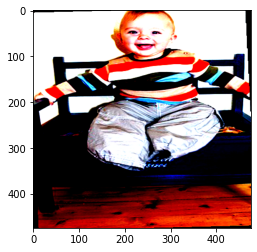

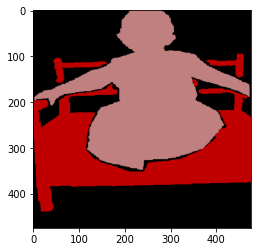

In [14]:
# 훈련용 이미지

# 이미지 데이터 읽기
index = 100
imges, anno_class_imges = train_dataset.__getitem__(index)

# 이미지 표시
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# 어노테이션 이미지 표시
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode='P')
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


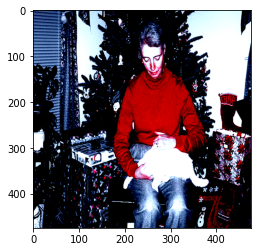

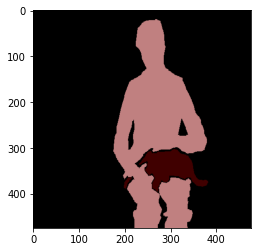

In [15]:
# 검증용 이미지

# 이미지 데이터 읽기
index = 100
imges, anno_class_imges = val_dataset.__getitem__(index)

# 이미지 표시
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# 어노테이션 이미지 표시
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode='P')
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()

# 2.Network Model

## 2.1 패키지 import

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## 2.2 PSPNet 네트워크 구조

In [29]:
class PSPNet(nn.Module):
  def __init__(self, n_classes):
    super(PSPNet, self).__init__()

    # 파라미터 설정
    block_config = [3, 4, 6, 3] # resnet50
    img_size = 475
    img_size_8 = 60 # img_size의 1/8로 설정

    # 4개의 모듈을 구성하는 서브 네트워크 준비
    self.feature_conv = FeatureMap_Convolution()
    self.feature_res_1 = ResidualBlockPSP(
        n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
    self.feature_res_2 = ResidualBlockPSP(
        n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
    self.feature_dilated_res_1 = ResidualBlockPSP(
        n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
    self.feature_dilated_res_2 = ResidualBlockPSP(
        n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)
    
    self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[6, 3, 2, 1],
                                          height=img_size_8, width=img_size_8)
    
    self.decode_feature = DecodePSPFeature(
        height=img_size, width=img_size, n_classes=n_classes)
    
    self.aux = AuxiliaryPSPlayers(
        in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
      x = self.feature_conv(x)
      x = self.feature_res_1(x)
      x = self.feature_res_2(x)
      x = self.feature_dilated_res_1(x)

      # Feature 모듈 중간에 Aux 모듈로
      output_aux = self.aux(x)

      x = self.feature_dilated_res_2(x)

      x = self.pyramid_pooling(x)
      output = self.decode_feature(x)

      return (output, output_aux)



## 2.3 Feature 모듈

In [30]:
class conv2DBatchNormRelu(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
    super(conv2DBatchNormRelu, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels,
                          kernel_size, stride, padding, dilation, bias=bias)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True) # inplace=True 설정으로, 입력을 저장하지 않고 출력을 계산하여 메모리 절약

  def forward(self, x):
    x = self.conv(x)
    x = self.batchnorm(x)
    outputs = self.relu(x)

    return outputs


In [31]:
class FeatureMap_Convolution(nn.Module):
  def __init__(self):
    super(FeatureMap_Convolution, self).__init__()

    # 합성곱 층1
    in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
    self.cbnr_1 = conv2DBatchNormRelu(
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias)
    
    # 합성곱 층2
    in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
    self.cbnr_2 = conv2DBatchNormRelu(
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias)
    
    # 합성곱 층3
    in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
    self.cbnr_3 = conv2DBatchNormRelu(
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias)
    
    # MaxPooling 층
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

  def forward(self, x):
    x = self.cbnr_1(x)
    x = self.cbnr_2(x)
    x = self.cbnr_3(x)
    outputs = self.maxpool(x)

    return outputs


In [32]:
class ResidualBlockPSP(nn.Sequential):
  def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
    super(ResidualBlockPSP, self).__init__()

    # bottleNeckPSP
    self.add_module(
        'block1',
        bottleNeckPSP(in_channels, mid_channels, out_channels, stride, dilation)
    )

    # bottleNeckIdentifyPSP
    for i in range(n_blocks - 1):
      self.add_module(
          'block' + str(i+2),
          bottleNeckIdentifyPSP(
              out_channels, mid_channels, stride, dilation
          )
      )

In [33]:
class conv2DBatchNorm(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
    super(conv2DBatchNorm, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, 
                          kernel_size, stride, padding, dilation, bias=bias)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv(x)
    outputs = self.batchnorm(x)

    return outputs
    

In [34]:
class bottleNeckPSP(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
    super(bottleNeckPSP, self).__init__()

    self.cbr_1 = conv2DBatchNormRelu(
        in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
    self.cbr_2 = conv2DBatchNormRelu(
        mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
    self.cb_3 = conv2DBatchNorm(
        mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
    
    # skip connection
    self.cb_residual = conv2DBatchNorm(
         in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)
    
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
    residual = self.cb_residual(x)

    return self.relu(conv + residual)

In [35]:
class bottleNeckIdentifyPSP(nn.Module):
  def __init__(self, in_channels, mid_channels, stride, dilation):
    super(bottleNeckIdentifyPSP, self).__init__()

    self.cbr_1 = conv2DBatchNormRelu(
        in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
    self.cbr_2 = conv2DBatchNormRelu(
        mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
    self.cb_3 = conv2DBatchNorm(
        mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
    residual = x

    return self.relu(conv + residual)

## 2.4 Pyramid Pooling 모듈

In [36]:
class PyramidPooling(nn.Module):
  def __init__(self, in_channels, pool_sizes, height, width):
    super(PyramidPooling, self).__init__()

    # forward에 사용하는 이미지 크기
    self.height = height
    self.width = width

    # 각 합성곱 층의 채널 수
    out_channels = int(in_channels / len(pool_sizes))

    # 각 합성곱 층
    # pool_sizes=  [6, 3, 2, 1]
    self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
    self.cbr_1 = conv2DBatchNormRelu(
        in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
    
    self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
    self.cbr_2 = conv2DBatchNormRelu(
        in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
    
    self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
    self.cbr_3 = conv2DBatchNormRelu(
        in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
    
    self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
    self.cbr_4 = conv2DBatchNormRelu(
        in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
    
  def forward(self, x):
    out1 = self.cbr_1(self.avpool_1(x))
    out1 = F.interpolate(out1, size=(self.height, self.width),
                         mode='bilinear', align_corners=True)
    
    out2 = self.cbr_2(self.avpool_2(x))
    out2 = F.interpolate(out2, size=(self.height, self.width),
                         mode='bilinear', align_corners=True)
    
    out3 = self.cbr_3(self.avpool_3(x))
    out3 = F.interpolate(out3, size=(self.height, self.width),
                         mode='bilinear', align_corners=True)
    
    out4 = self.cbr_4(self.avpool_4(x))
    out4 = F.interpolate(out4, size=(self.height, self.width),
                         mode='bilinear', align_corners=True)
    
    # 최종적으로 결합. dim=1로 채널 수 차원으로 결합 (512*4 +  2048 = 4096)
    output = torch.cat([x, out1, out2, out3, out4], dim=1)

    return output

## 2.5 Decoder 모듈

In [37]:
class DecodePSPFeature(nn.Module):
  def __init__(self, height, width, n_classes):
    super(DecodePSPFeature, self).__init__()

    # forward에 사용하는 이미지 크기
    self.height = height
    self.width = width

    self.cbr = conv2DBatchNormRelu(in_channels=4096, out_channels=512, kernel_size=3, 
                                   stride=1, padding=1, dilation=1, bias=False)
    self.dropout = nn.Dropout2d(p=0.1)
    self.classification = nn.Conv2d(in_channels=512, out_channels=n_classes,
                                    kernel_size=1, stride=1, padding=0)
    
  def forward(self, x):
    x = self.cbr(x)
    x = self.dropout(x)
    x = self.classification(x)
    output = F.interpolate(x, size=(self.height, self.width),
                           mode='bilinear', align_corners=True)
    # F.interpolate() 사용법 
    # torch.nn.functional.interpolate(input, size=None, scale_factor=None, mode='nearest', align_corners=None, recompute_scale_factor=None)
    
    return output


## 2.6 AuxLoss 모듈

In [38]:
class AuxiliaryPSPlayers(nn.Module):
  def __init__(self, in_channels, height, width, n_classes):
    super(AuxiliaryPSPlayers, self).__init__()

    # forward에 사용하는 이미지 크기
    self.height = height
    self.width = width

    self.cbr = conv2DBatchNormRelu(in_channels=in_channels, out_channels=256, kernel_size=3, 
                                   stride=1, padding=1, dilation=1, bias=False)
    self.dropout = nn.Dropout2d(p=0.1)
    self.classification = nn.Conv2d(in_channels=256, out_channels=n_classes,
                                    kernel_size=1, stride=1, padding=0)
    
  def forward(self, x):
    x = self.cbr(x)
    x = self.dropout(x)
    x = self.classification(x)
    output = F.interpolate(x, size=(self.height, self.width),
                           mode='bilinear', align_corners=True)
    
    return output


In [39]:
# 동작 확인

# 모델 정의
net = PSPNet(n_classes=21)
net

PSPNet(
  (feature_conv): FeatureMap_Convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [ ]:
# 더미 데이터 작성
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 475, 475)

# 계산
outputs = net(dummy_img)
print(outputs)


# 3.PSPNet training

## 3.1 사전 준비

In [66]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

In [67]:
# 초기설정
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## 3.2 네트워크 모델 작성

In [41]:
# 파인튜닝으로 PSPNet 작성
# ADE20K 데이터셋의 학습된 모델 사용. ADE20K는 클래스 수가 150

net = PSPNet(n_classes=150)

# ADE20K 학습된 파라미터 읽기
state_dict = torch.load('./weights/pspnet50_ADE20K.pth')
net.load_state_dict(state_dict)

# 분류용 합성곱층을, 출력수  21로 바꿈
n_classes = 21
net.decode_feature.classification = nn.Conv2d(
    in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

net.aux.classification = nn.Conv2d(
    in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

# 교체한 합성곱층을 초기화. 활성화 함수가 시그모이드 함수이므로 Xavier 초기화 사용
def weights_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.xavier_normal_(m.weight.data)
    if m.bias is not None: # 바이어스 항이 있는 경우
      nn.init.constant_(m.bias, 0.0)

net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)

print('네트워크 설정 완료. 학습된 가중치를 로드했습니다')

네트워크 설정 완료. 학습된 가중치를 로드했습니다


In [42]:
net

PSPNet(
  (feature_conv): FeatureMap_Convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

## 3.3 손실함수 정의

In [44]:
# 손실함수 정의
class PSPLoss(nn.Module):
  def __init__(self, aux_weight=0.4):
    super(PSPLoss, self).__init__()
    self.aux_weight = aux_weight

  def forward(self, outputs, targets):
    '''
    손실함수 계산

    Parameters
    ----------
    outputs : PSPNet의 출력 (tuple)
        (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))
    
    targets : [num_batch, 475, 475]
        정답 어노테이션 정보
    
    Returns
    -------
    loss : 텐서
        손실값
    '''

    loss = F.cross_entropy(outputs[0], targets, reduction='mean')
    loss_aux = F.cross_entropy(outputs[1], targets, reduction='meaan')

    return loss + self.aux_weight*loss_aux

criterion = PSPLoss(aux_weight=0.4)

## 3.4 최적화기법 설정

In [ ]:
# 파인튜닝으로 학습률 작게

optimizer = optim.SGD([
            {'params': net.feature_conv.parameters(), 'lr': 1e-3},
            {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
            {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
            {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
            {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
            {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
            {'params': net.decode_feature.parameters(), 'lr': 1e-2},
            {'params': net.aux.parameters(), 'lr': 1e-2},
], momentum=0.9, weight_decay=0.0001)

# 스케줄러 설정
def lambda_epoch(epoch):
  max_epoch = 30
  return math.pow((1-epoch/max_epoch), 0.9)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

## 3.5 학습 및 검증 실시

In [47]:
def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):
  
  # GPU 사용 가능한지 확인
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print('사용 장치: ', device)

  # 네트워크를 GPU로
  net.to(device)

  # 네트워크가 어느 정도 고정되면 가속화한다
  torch.backends.cudnn.benchmark = True

  # 이미지 개수
  num_train_imgs = len(dataloaders_dict['train'].dataset)
  num_val_imgs = len(dataloaders_dict['val'].dataset)
  batch_size = dataloaders_dict['train'].batch_size

  # 반복자의 카운터 설정
  iteration = 1
  logs = []

  # multiple minibatch
  batch_multiplier = 3

  # epoch 루프
  for epoch in range(num_epochs):

    # 시작 시간 저장
    t_epoch_start = time.time()
    t_iter_start = time.time()
    epoch_train_loss = 0.0 # epoch의 손실 합
    epoch_val_loss = 0.0 # epoch의 손실 합

    print('-------------')
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')

    # epoch별 훈련 및 검증 루프
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()   # 모델을 훈련 모드로
        scheduler.step()  # 최적화 scheduler 갱신
        optimizer.zero_grad()
        print('(train)')

      else:
        if((epoch+1) % 5 == 0):
          net.eval()  # 모델을 검증 모드로
          print('-------------')
          print('(val)')
        else:
          # 검증은  다섯  번 중 한 번만 수행
          continue
      
      # 데이터 로더에서 minibatch씩 꺼내 루프
      count = 0 # multiple minibatch
      for imges, anno_class_imges in dataloaders_dict[phase]:
        # 미니배치 크기가 1이면 배치 정규화에서 오류가 발생하므로 회피
        if imges.size()[0]  == 1:
          continue
        
        #  GPU가 사용가능하면 GPU에 데이터를 보낸다
        imges =  imges.to(device)
        anno_class_imges = anno_class_imges.to(device)

        # multiple minibatch로 파라미터 갱신
        if (phase == 'train') and  (count == 0):
          optimizer.step()
          optimizer.zero_grad()
          count = batch_multiplier

        # 순전파(forward) 계산
        with torch.set_grad_enabled(phase == 'train'):
          outputs = net(imges)
          loss = criterion(outputs, anno_class_imges.long()) / batch_multiplier

          # 훈련시에는 역전파
          if phase == 'train':
            loss.backward()  # 경사 계산
            count -= 1  # multiple minibatch

            if (iteration % 10  == 0):  # 10 iter에 한 번, loss를 표시
              t_iter_finish = time.time()
              duration =  t_iter_finish - t_iter_start
              print('반복 {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size*batch_multiplier, duration))
              t_iter_start = time.time()

            epoch_train_loss += loss.item() * batch_multiplier
            iteration += 1

          # 검증시
          else:
            epoch_val_loss += loss.item() * batch_multiplier

    # epoch의 phase별 loss와 정답률
    t_epoch_finish = time.time()
    print('-------------')
    print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
        epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
    print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
    t_epoch_start = time.time()

    # 로그 저장
    log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss / num_train_imgs,
                 'val_loss': epoch_val_loss / num_val_imgs}
    logs.append(log_epoch)
    df = pd.DataFrame(logs)
    df.to_csv('log_output.csv')

  # 최후의 네트워크를 저장
  torch.save(net.state_dict(), 'weights/pspnet50_' +  str(epoch+1) + '.pth')



In [ ]:
# 학습 및 검증 실행
num_epochs = 30
train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)

# 4.PSPNet inference

## 4.1 사전 준비

In [48]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [ ]:
# 파일 경로 리스트 주비

from utils.dataloader import make_datapath_list, DataTransform

rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# 나중에 어노테이션 이미지만 사용한다


In [ ]:
# 네트워크 준비

from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 학습된 파라미터를 로드
state_dict = torch.load("./weights/pspnet50_30.pth", map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다')


## 4.2 추론 실행

In [ ]:
# 1. 원본 화상 표시
image_file_path = "./data/cowboy-757575_640.jpg"
img = Image.open(image_file_path)   # [높이][폭][색RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 전처리 클래스 작성
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 전처리
# 어노테이션 이미지를 준비하여, 색상 팔레트 정보를 추출
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [높이][폭]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)

# 4. PSPNet으로 추론
net.eval()
x = img.unsqueeze(0)  # 미니 배치화: torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss 측은 무시, y의 크기는 torch.Size([1, 21, 475, 475])

# 5. PSPNet의 출력으로 최대 클래스를 구해, 색상 팔레트 형식으로 하여, 이미지 크기를 원래대로 되돌린다
y = y[0].detach().numpy()  # y: torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

# 6. 이미지를 투과시켜 겹친다
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # 색상 팔레트 형식을 RGBA로 변환

for x in range(img_width):
    for y in range(img_height):
        # 추론 결과 이미지의 픽셀 데이터를 취득
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)의 배경이라면 그대로 투과시킨다
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # 그 외 색상은 준비된 이미지에 픽셀을 기록한다
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 투과율을 150으로 지정한다

img = Image.open(image_file_path)   # [높이][폭][색RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()
